In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("../data/processed.csv")

In [3]:
df.isnull().sum()

person_age                     0
person_income                  0
person_home_ownership          0
person_emp_length              0
loan_intent                    0
loan_amnt                      0
loan_int_rate                  0
loan_status                    0
loan_percent_income            0
cb_person_default_on_file      0
cb_person_cred_hist_length     0
age_group                      0
loan_amnt_group                0
income_group                   0
loan_to_income                 0
loan_to_emp_length_ratio       0
int_rate_to loan_amnt_ratio    0
dtype: int64

In [4]:
df.duplicated().sum()

0

## 1. Data processing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [6]:

X = df.drop(columns=['loan_status']) 
Y = df['loan_status']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=12)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=12)

In [7]:
numeric_cols = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length', 'loan_to_income', 
    'loan_to_emp_length_ratio', 'int_rate_to loan_amnt_ratio'
]

ohe_cols = [
    'person_home_ownership', 'loan_intent', 
    'cb_person_default_on_file', 'age_group', 
    'loan_amnt_group', 'income_group'
]

In [8]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(x_train[ohe_cols])

x_train_ohe = pd.DataFrame(ohe.transform(x_train[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols))
x_val_ohe = pd.DataFrame(ohe.transform(x_val[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols))
x_test_ohe = pd.DataFrame(ohe.transform(x_test[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols))
x_train_ohe.reset_index(drop=True, inplace=True)
x_val_ohe.reset_index(drop=True, inplace=True)
x_test_ohe.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
x_train = x_train.drop(columns=ohe_cols)
x_val = x_val.drop(columns=ohe_cols)
x_test = x_test.drop(columns=ohe_cols)
x_train = pd.concat([x_train, x_train_ohe], axis=1)
x_val = pd.concat([x_val, x_val_ohe], axis=1)
x_test = pd.concat([x_test, x_test_ohe], axis=1)

scaler = StandardScaler()
scaler.fit(x_train[numeric_cols])

x_train_scaled = pd.DataFrame(scaler.transform(x_train[numeric_cols]), columns=numeric_cols)
x_val_scaled = pd.DataFrame(scaler.transform(x_val[numeric_cols]), columns=numeric_cols)
x_test_scaled = pd.DataFrame(scaler.transform(x_test[numeric_cols]), columns=numeric_cols)

x_train_scaled.reset_index(drop=True, inplace=True)
x_val_scaled.reset_index(drop=True, inplace=True)
x_test_scaled.reset_index(drop=True, inplace=True)

x_train = x_train.drop(columns=numeric_cols)
x_val = x_val.drop(columns=numeric_cols)
x_test = x_test.drop(columns=numeric_cols)

x_train = pd.concat([x_train, x_train_scaled], axis=1)
x_val = pd.concat([x_val, x_val_scaled], axis=1)
x_test = pd.concat([x_test, x_test_scaled], axis=1)

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")


x_train shape: (22679, 36)
x_val shape: (4860, 36)
x_test shape: (4860, 36)


## 2. Modelisation & Evaluation

In [9]:
import mlflow
from scipy.stats import randint, uniform
import mlflow.sklearn
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report



In [10]:
scale_pos_weight = ((y_train == 0).sum() / (y_train == 1).sum()) * 1.2


In [11]:
models = {
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, scale_pos_weight= scale_pos_weight),
}


In [12]:
mlflow.set_tracking_uri("file:///media/Data/Repositories/credit_risk_prediction/mlruns")
mlflow.set_experiment("Binary")

<Experiment: artifact_location='file:///media/Data/Repositories/credit_risk_prediction/mlruns/907417149689263115', creation_time=1739026105253, experiment_id='907417149689263115', last_update_time=1739026105253, lifecycle_stage='active', name='Binary', tags={}>

In [13]:
def evaluate_model(model, x_train, y_train, x_test, y_test, threshold=0.42):
    """Binary
    Entraîne le modèle, applique le seuil de classification et calcule les métriques.
    """
    model.fit(x_train, y_train)
    # Probabilités prédites pour la classe 1
    probabilities = model.predict_proba(x_test)[:, 1]
    # Application du seuil personnalisé
    predictions = (probabilities >= threshold).astype(int)
    
    auc_score = roc_auc_score(y_test, probabilities)
    f1 = f1_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)
    
    return auc_score, conf_matrix, class_report, f1, recall


for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        auc, conf_matrix, class_report, f1, recall = evaluate_model(model, x_train, y_train, x_val, y_val)
        
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("recall", recall)
        mlflow.log_text(str(conf_matrix), "confusion_matrix.txt")
        mlflow.log_text(class_report, "classification_report.txt")
        mlflow.sklearn.log_model(model, artifact_path="model")


2025/02/20 22:21:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/20 22:21:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/20 22:21:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623


2025/02/20 22:21:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


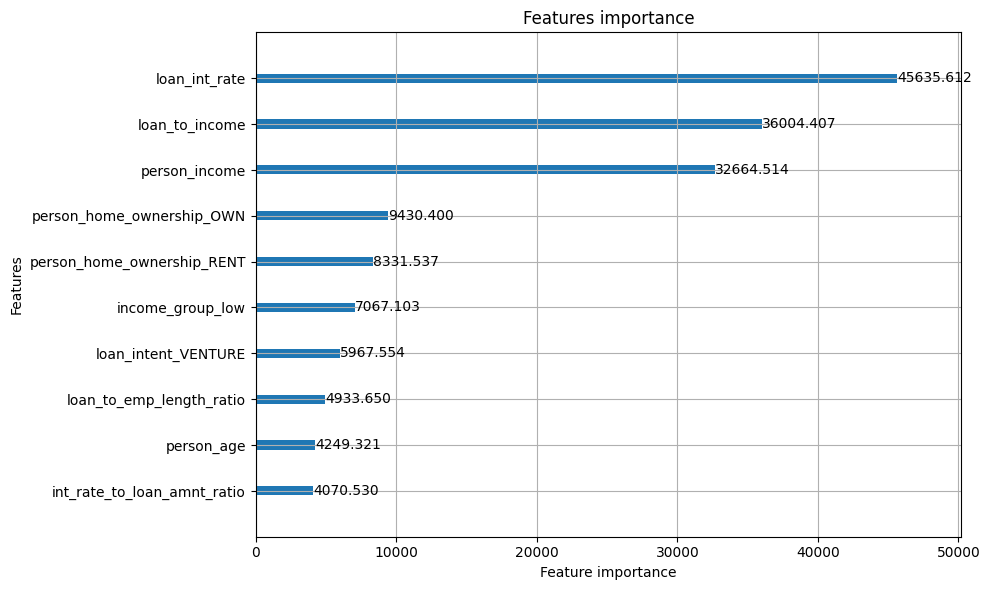

In [14]:
import lightgbm as lgb
import matplotlib.pyplot as plt

model = LGBMClassifier(random_state=42, scale_pos_weight= scale_pos_weight, class_weight="balanced")
model.fit(x_train, y_train)
ax = lgb.plot_importance(model, 
                          max_num_features=10,        
                          importance_type='gain',    
                          figsize=(10, 6))
plt.title("Features importance")
plt.tight_layout()
plt.show()


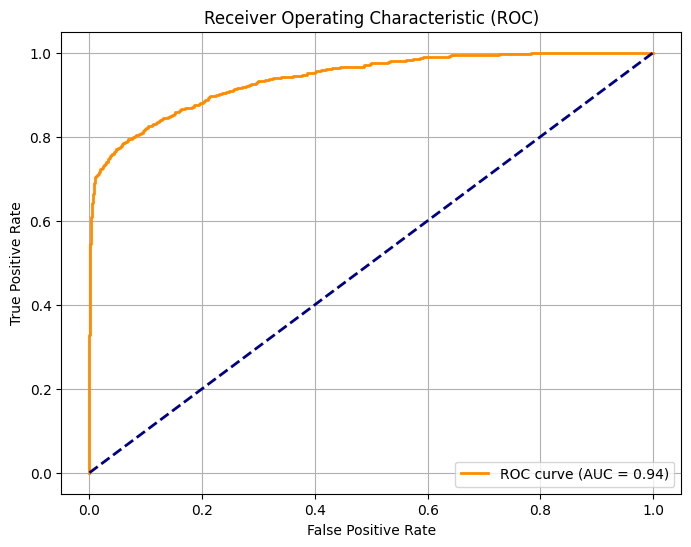

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, x_val, y_val):
    """
    Trace la courbe ROC pour un modèle de classification binaire.
    Parameters:
        model: Le modèle entraîné qui doit supporter la méthode predict_proba.
        x_val: Les données de validation (features).
        y_val: Les vraies étiquettes (labels) de validation.
    """
    y_prob = model.predict_proba(x_val)[:, 1]    
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(model, x_val, y_val)


*`Conclusion`* : LightGBM est le plus efficient 

## 3. Tuning

In [16]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_recall_curve, f1_score, roc_auc_score
import numpy as np


In [17]:
scale_pos_weight = len(y_train) / (2.0 * sum(y_train))


In [18]:
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, f1_score, recall_score

def objective(trial):
    # Paramètres du modèle LightGBM à tester
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),  # Handle class imbalance
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)  # Avoid overfitting
    }

    # Entraînement du modèle avec les paramètres
    model = lgb.LGBMClassifier(**param)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)])

    # Prédictions pour calculer le score
    y_pred_prob = model.predict_proba(x_val)[:, 1]
    
    # Adjusting the threshold to prioritize recall
    threshold = 0.3  # Lower threshold to favor recall
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculating the AUC, F1, and Recall scores
    auc = roc_auc_score(y_val, y_pred_prob)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # You can optimize based on AUC, F1, or recall; here, it's focused on recall
    return recall  # Prioritizing recall for optimization

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')  # Maximize recall
study.optimize(objective, n_trials=300)

# Meilleurs hyperparamètres trouvés
params = study.best_params
print("Meilleurs paramètres: ", params)

# You can print the final performance metrics
print("Final Recall after optimization:", study.best_value)


[I 2025-02-20 22:21:48,515] A new study created in memory with name: no-name-606af310-86a7-4e2c-8f6b-b8c6b9e2b42b


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:21:49,809] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 4, 'num_leaves': 81, 'n_estimators': 630, 'scale_pos_weight': 1.6275735328543497, 'learning_rate': 4.041182550700904e-05, 'subsample': 0.8605526484084616, 'colsample_bytree': 0.7408273184814436, 'min_child_samples': 71}. Best is trial 0 with value: 0.0.
[I 2025-02-20 22:21:49,960] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 3, 'num_leaves': 52, 'n_estimators': 101, 'scale_pos_weight': 2.361619521175683, 'learning_rate': 0.00037888961858476515, 'subsample': 0.7944025931894549, 'colsample_bytree': 0.9594770705038208, 'min_child_samples': 16}. Best is trial 0 with value: 0.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:21:52,198] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 9, 'num_leaves': 80, 'n_estimators': 656, 'scale_pos_weight': 4.010761113117121, 'learning_rate': 0.00013189251814250662, 'subsample': 0.8000801087504623, 'colsample_bytree': 0.8351002354005851, 'min_child_samples': 65}. Best is trial 0 with value: 0.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:21:53,009] Trial 3 finished with value: 0.9868049010367578 and parameters: {'max_depth': 4, 'num_leaves': 56, 'n_estimators': 531, 'scale_pos_weight': 8.628789383979544, 'learning_rate': 0.00983832826672986, 'subsample': 0.7486025679022942, 'colsample_bytree': 0.978942860849596, 'min_child_samples': 99}. Best is trial 3 with value: 0.9868049010367578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:21:53,158] Trial 4 finished with value: 0.0 and parameters: {'max_depth': 4, 'num_leaves': 63, 'n_estimators': 70, 'scale_pos_weight': 1.108508342414023, 'learning_rate': 0.0013567348994286052, 'subsample': 0.9737477535171102, 'colsample_bytree': 0.9713603567215552, 'min_child_samples': 97}. Best is trial 3 with value: 0.9868049010367578.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:21:56,129] Trial 5 finished with value: 0.825636192271442 and parameters: {'max_depth': 9, 'num_leaves': 77, 'n_estimators': 925, 'scale_pos_weight': 1.9570976338480297, 'learning_rate': 0.016398130018059655, 'subsample': 0.945457630264257, 'colsample_bytree': 0.8057451284221884, 'min_child_samples': 11}. Best is trial 3 with value: 0.9868049010367578.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:21:57,193] Trial 6 finished with value: 0.8868991517436381 and parameters: {'max_depth': 8, 'num_leaves': 54, 'n_estimators': 399, 'scale_pos_weight': 6.4544563645920086, 'learning_rate': 0.08573950543897087, 'subsample': 0.7379173386899555, 'colsample_bytree': 0.9061719451086336, 'min_child_samples': 42}. Best is trial 3 with value: 0.9868049010367578.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623


[I 2025-02-20 22:21:59,027] Trial 7 finished with value: 0.0 and parameters: {'max_depth': 11, 'num_leaves': 20, 'n_estimators': 784, 'scale_pos_weight': 7.01757673753621, 'learning_rate': 1.497174680004225e-05, 'subsample': 0.8756623590902386, 'colsample_bytree': 0.8488106176314717, 'min_child_samples': 36}. Best is trial 3 with value: 0.9868049010367578.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:01,287] Trial 8 finished with value: 0.0 and parameters: {'max_depth': 6, 'num_leaves': 56, 'n_estimators': 937, 'scale_pos_weight': 8.057165085908023, 'learning_rate': 3.7524629397553785e-05, 'subsample': 0.7659652112393502, 'colsample_bytree': 0.7122007132562586, 'min_child_samples': 93}. Best is trial 3 with value: 0.9868049010367578.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623


[I 2025-02-20 22:22:03,954] Trial 9 finished with value: 0.9717247879359096 and parameters: {'max_depth': 12, 'num_leaves': 38, 'n_estimators': 966, 'scale_pos_weight': 9.04952575952035, 'learning_rate': 0.0007112963406278767, 'subsample': 0.8062396845125421, 'colsample_bytree': 0.8011480562068084, 'min_child_samples': 43}. Best is trial 3 with value: 0.9868049010367578.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:04,915] Trial 10 finished with value: 0.9915174363807728 and parameters: {'max_depth': 6, 'num_leaves': 96, 'n_estimators': 357, 'scale_pos_weight': 9.841640987145222, 'learning_rate': 0.00608080591542397, 'subsample': 0.7056997278483406, 'colsample_bytree': 0.9119408554381979, 'min_child_samples': 82}. Best is trial 10 with value: 0.9915174363807728.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]:

[I 2025-02-20 22:22:05,813] Trial 11 finished with value: 0.9924599434495759 and parameters: {'max_depth': 6, 'num_leaves': 98, 'n_estimators': 379, 'scale_pos_weight': 9.795324648875287, 'learning_rate': 0.007343595273741962, 'subsample': 0.7031312822032766, 'colsample_bytree': 0.9112552437376771, 'min_child_samples': 85}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:06,703] Trial 12 finished with value: 0.9905749293119699 and parameters: {'max_depth': 6, 'num_leaves': 96, 'n_estimators': 307, 'scale_pos_weight': 9.881092729623088, 'learning_rate': 0.006058423349128626, 'subsample': 0.7055073503180118, 'colsample_bytree': 0.9074527307454027, 'min_child_samples': 76}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:22:07,659] Trial 13 finished with value: 0.9877474081055608 and parameters: {'max_depth': 6, 'num_leaves': 98, 'n_estimators': 266, 'scale_pos_weight': 9.980602869455245, 'learning_rate': 0.003124637646940182, 'subsample': 0.7051600215214008, 'colsample_bytree': 0.9147227616535386, 'min_child_samples': 83}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]:

[I 2025-02-20 22:22:08,776] Trial 14 finished with value: 0.9123468426013195 and parameters: {'max_depth': 7, 'num_leaves': 91, 'n_estimators': 433, 'scale_pos_weight': 5.0290773030451374, 'learning_rate': 0.04895422302251657, 'subsample': 0.9145024972204502, 'colsample_bytree': 0.8876098868989916, 'min_child_samples': 58}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:09,443] Trial 15 finished with value: 0.9311969839773798 and parameters: {'max_depth': 5, 'num_leaves': 70, 'n_estimators': 252, 'scale_pos_weight': 7.601439133864699, 'learning_rate': 0.002160731522581758, 'subsample': 0.7006072085950135, 'colsample_bytree': 0.9311246179248351, 'min_child_samples': 84}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:10,945] Trial 16 finished with value: 0.9453345900094251 and parameters: {'max_depth': 8, 'num_leaves': 88, 'n_estimators': 439, 'scale_pos_weight': 6.144337244941401, 'learning_rate': 0.02245942665833046, 'subsample': 0.7725415278366224, 'colsample_bytree': 0.8691391003847405, 'min_child_samples': 85}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:12,912] Trial 17 finished with value: 0.9839773798303487 and parameters: {'max_depth': 7, 'num_leaves': 99, 'n_estimators': 533, 'scale_pos_weight': 8.92671328575863, 'learning_rate': 0.0034021421609095478, 'subsample': 0.8176625957124937, 'colsample_bytree': 0.9366521050988809, 'min_child_samples': 54}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623


[I 2025-02-20 22:22:13,539] Trial 18 finished with value: 0.0 and parameters: {'max_depth': 10, 'num_leaves': 86, 'n_estimators': 136, 'scale_pos_weight': 4.916314226013898, 'learning_rate': 0.00037633810499699226, 'subsample': 0.7360649431080523, 'colsample_bytree': 0.8192610619559354, 'min_child_samples': 74}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:22:14,215] Trial 19 finished with value: 0.9170593779453345 and parameters: {'max_depth': 5, 'num_leaves': 73, 'n_estimators': 201, 'scale_pos_weight': 3.5175631413880097, 'learning_rate': 0.02625999649766439, 'subsample': 0.8382731410272883, 'colsample_bytree': 0.9969962764555473, 'min_child_samples': 88}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:14,823] Trial 20 finished with value: 0.9915174363807728 and parameters: {'max_depth': 3, 'num_leaves': 42, 'n_estimators': 359, 'scale_pos_weight': 8.104542526660753, 'learning_rate': 0.006748497413014368, 'subsample': 0.8948586858289347, 'colsample_bytree': 0.8745276411413512, 'min_child_samples': 66}. Best is trial 11 with value: 0.9924599434495759.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:15,349] Trial 21 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 41, 'n_estimators': 328, 'scale_pos_weight': 9.274398741325243, 'learning_rate': 0.0056095284359498595, 'subsample': 0.9007638040436334, 'colsample_bytree': 0.877100624054145, 'min_child_samples': 63}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:16,036] Trial 22 finished with value: 0.9896324222431668 and parameters: {'max_depth': 5, 'num_leaves': 27, 'n_estimators': 354, 'scale_pos_weight': 9.41958871865467, 'learning_rate': 0.010004704129222313, 'subsample': 0.9293578518319802, 'colsample_bytree': 0.9430910501154218, 'min_child_samples': 58}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623


[I 2025-02-20 22:22:16,605] Trial 23 finished with value: 0.8171536286522149 and parameters: {'max_depth': 7, 'num_leaves': 43, 'n_estimators': 188, 'scale_pos_weight': 9.969011047704836, 'learning_rate': 0.0011302388536404907, 'subsample': 0.9638559568570086, 'colsample_bytree': 0.8715861478071847, 'min_child_samples': 75}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:17,319] Trial 24 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 65, 'n_estimators': 472, 'scale_pos_weight': 8.443154050178864, 'learning_rate': 0.004303892452071906, 'subsample': 0.9973972078702829, 'colsample_bytree': 0.778233723103065, 'min_child_samples': 81}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:18,307] Trial 25 finished with value: 0.9868049010367578 and parameters: {'max_depth': 3, 'num_leaves': 65, 'n_estimators': 609, 'scale_pos_weight': 7.364350722085652, 'learning_rate': 0.002611212089835929, 'subsample': 0.9997157206825307, 'colsample_bytree': 0.7589475827760321, 'min_child_samples': 50}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from

[I 2025-02-20 22:22:19,157] Trial 26 finished with value: 0.9726672950047125 and parameters: {'max_depth': 4, 'num_leaves': 33, 'n_estimators': 498, 'scale_pos_weight': 8.421651345440347, 'learning_rate': 0.05053549410873339, 'subsample': 0.8953623274386094, 'colsample_bytree': 0.7575912294264101, 'min_child_samples': 65}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:20,438] Trial 27 finished with value: 0.8878416588124411 and parameters: {'max_depth': 3, 'num_leaves': 48, 'n_estimators': 739, 'scale_pos_weight': 8.91647761046875, 'learning_rate': 0.0005614331419985115, 'subsample': 0.9857476792897006, 'colsample_bytree': 0.7739806225808853, 'min_child_samples': 25}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:21,536] Trial 28 finished with value: 0.9736098020735156 and parameters: {'max_depth': 5, 'num_leaves': 30, 'n_estimators': 481, 'scale_pos_weight': 6.682731291528807, 'learning_rate': 0.016767261932759285, 'subsample': 0.9455610852766517, 'colsample_bytree': 0.8541304852258954, 'min_child_samples': 91}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:22,610] Trial 29 finished with value: 0.9717247879359096 and parameters: {'max_depth': 4, 'num_leaves': 67, 'n_estimators': 617, 'scale_pos_weight': 7.704073180512404, 'learning_rate': 0.0014289766276128091, 'subsample': 0.8537755099105275, 'colsample_bytree': 0.7278058490027328, 'min_child_samples': 69}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:23,539] Trial 30 finished with value: 0.0 and parameters: {'max_depth': 3, 'num_leaves': 47, 'n_estimators': 567, 'scale_pos_weight': 5.738724264584872, 'learning_rate': 0.00012838180257453003, 'subsample': 0.8371677924935316, 'colsample_bytree': 0.7878361468136564, 'min_child_samples': 79}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:24,549] Trial 31 finished with value: 0.9896324222431668 and parameters: {'max_depth': 6, 'num_leaves': 91, 'n_estimators': 326, 'scale_pos_weight': 9.321272794505989, 'learning_rate': 0.005009497472351441, 'subsample': 0.7234799119662192, 'colsample_bytree': 0.8932783405037269, 'min_child_samples': 80}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-ch

[I 2025-02-20 22:22:25,528] Trial 32 finished with value: 0.9896324222431668 and parameters: {'max_depth': 5, 'num_leaves': 84, 'n_estimators': 405, 'scale_pos_weight': 9.452826945906345, 'learning_rate': 0.009838886972114375, 'subsample': 0.7798416175163703, 'colsample_bytree': 0.9262791863199821, 'min_child_samples': 71}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:26,008] Trial 33 finished with value: 0.9886899151743638 and parameters: {'max_depth': 4, 'num_leaves': 76, 'n_estimators': 268, 'scale_pos_weight': 8.179666704312215, 'learning_rate': 0.006181012382450909, 'subsample': 0.8813009518823163, 'colsample_bytree': 0.8321828148832693, 'min_child_samples': 95}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:22:26,665] Trial 34 finished with value: 0.9858623939679547 and parameters: {'max_depth': 3, 'num_leaves': 95, 'n_estimators': 469, 'scale_pos_weight': 9.49336163106347, 'learning_rate': 0.0020057938215320807, 'subsample': 0.7462228372886359, 'colsample_bytree': 0.9559055298192033, 'min_child_samples': 89}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:27,296] Trial 35 finished with value: 0.9896324222431668 and parameters: {'max_depth': 4, 'num_leaves': 59, 'n_estimators': 377, 'scale_pos_weight': 8.626089196842932, 'learning_rate': 0.004258334221121632, 'subsample': 0.7207873549126715, 'colsample_bytree': 0.890970239517174, 'min_child_samples': 80}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:29,558] Trial 36 finished with value: 0.88124410933082 and parameters: {'max_depth': 9, 'num_leaves': 80, 'n_estimators': 699, 'scale_pos_weight': 2.9091256442496176, 'learning_rate': 0.009685591879232592, 'subsample': 0.9116745997688018, 'colsample_bytree': 0.851075617750576, 'min_child_samples': 99}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:30,414] Trial 37 finished with value: 0.0 and parameters: {'max_depth': 8, 'num_leaves': 91, 'n_estimators': 198, 'scale_pos_weight': 8.721690470766385, 'learning_rate': 0.0003233197490431534, 'subsample': 0.9523261467201575, 'colsample_bytree': 0.9627102976967644, 'min_child_samples': 60}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:31,083] Trial 38 finished with value: 0.9707822808671065 and parameters: {'max_depth': 6, 'num_leaves': 61, 'n_estimators': 300, 'scale_pos_weight': 9.434918541989378, 'learning_rate': 0.04132556022867797, 'subsample': 0.7557059734903657, 'colsample_bytree': 0.9180741395163036, 'min_child_samples': 71}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:31,268] Trial 39 finished with value: 0.9604147031102733 and parameters: {'max_depth': 5, 'num_leaves': 83, 'n_estimators': 54, 'scale_pos_weight': 7.118148210283513, 'learning_rate': 0.014580564187300655, 'subsample': 0.790191658110025, 'colsample_bytree': 0.8218731986040877, 'min_child_samples': 62}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:32,566] Trial 40 finished with value: 0.9660697455230914 and parameters: {'max_depth': 10, 'num_leaves': 23, 'n_estimators': 567, 'scale_pos_weight': 7.848687163118147, 'learning_rate': 0.0015884556706393497, 'subsample': 0.8195222071192007, 'colsample_bytree': 0.9460937657011124, 'min_child_samples': 51}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:33,137] Trial 41 finished with value: 0.9915174363807728 and parameters: {'max_depth': 3, 'num_leaves': 37, 'n_estimators': 374, 'scale_pos_weight': 8.314262659363894, 'learning_rate': 0.007107050640800506, 'subsample': 0.8920996019887054, 'colsample_bytree': 0.8766070537323295, 'min_child_samples': 66}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:33,613] Trial 42 finished with value: 0.9839773798303487 and parameters: {'max_depth': 3, 'num_leaves': 40, 'n_estimators': 346, 'scale_pos_weight': 9.016234336473683, 'learning_rate': 0.02798760298487655, 'subsample': 0.8707732253179739, 'colsample_bytree': 0.8612527891203612, 'min_child_samples': 68}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:34,358] Trial 43 finished with value: 0.9943449575871819 and parameters: {'max_depth': 4, 'num_leaves': 49, 'n_estimators': 444, 'scale_pos_weight': 9.976946906255412, 'learning_rate': 0.004184127395520171, 'subsample': 0.926173230336315, 'colsample_bytree': 0.8953145471303703, 'min_child_samples': 76}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-02-20 22:22:35,147] Trial 44 finished with value: 0.9905749293119699 and parameters: {'max_depth': 4, 'num_leaves': 49, 'n_estimators': 427, 'scale_pos_weight': 9.677149040041895, 'learning_rate': 0.0028906566776759042, 'subsample': 0.9321414895227904, 'colsample_bytree': 0.9014969927849481, 'min_child_samples': 76}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:36,081] Trial 45 finished with value: 0.9915174363807728 and parameters: {'max_depth': 4, 'num_leaves': 52, 'n_estimators': 513, 'scale_pos_weight': 9.926824571760084, 'learning_rate': 0.004180287927599587, 'subsample': 0.98046256984013, 'colsample_bytree': 0.9158005361734004, 'min_child_samples': 87}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:22:37,133] Trial 46 finished with value: 0.9858623939679547 and parameters: {'max_depth': 6, 'num_leaves': 58, 'n_estimators': 445, 'scale_pos_weight': 9.10619794712861, 'learning_rate': 0.013992419066575586, 'subsample': 0.916761550528291, 'colsample_bytree': 0.8390996809411483, 'min_child_samples': 82}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:37,690] Trial 47 finished with value: 0.76248821866164 and parameters: {'max_depth': 5, 'num_leaves': 45, 'n_estimators': 246, 'scale_pos_weight': 8.600946885810014, 'learning_rate': 0.000805534825250918, 'subsample': 0.9554312055467625, 'colsample_bytree': 0.9000249827369226, 'min_child_samples': 93}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:39,321] Trial 48 finished with value: 0.9877474081055608 and parameters: {'max_depth': 7, 'num_leaves': 36, 'n_estimators': 558, 'scale_pos_weight': 9.672785281762284, 'learning_rate': 0.008728140215883457, 'subsample': 0.7212705205772352, 'colsample_bytree': 0.883164702921272, 'min_child_samples': 72}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:39,885] Trial 49 finished with value: 0.9792648444863337 and parameters: {'max_depth': 3, 'num_leaves': 50, 'n_estimators': 290, 'scale_pos_weight': 9.169417369119259, 'learning_rate': 0.0887447380968122, 'subsample': 0.9932658945705234, 'colsample_bytree': 0.9794267395839015, 'min_child_samples': 77}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:41,413] Trial 50 finished with value: 0.9227144203581527 and parameters: {'max_depth': 4, 'num_leaves': 100, 'n_estimators': 816, 'scale_pos_weight': 4.3427165104837595, 'learning_rate': 0.0020656498772618956, 'subsample': 0.9729670575841667, 'colsample_bytree': 0.9239099585359408, 'min_child_samples': 83}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:42,131] Trial 51 finished with value: 0.9915174363807728 and parameters: {'max_depth': 3, 'num_leaves': 43, 'n_estimators': 396, 'scale_pos_weight': 8.057752900803127, 'learning_rate': 0.005705443087649815, 'subsample': 0.9022907085869534, 'colsample_bytree': 0.8789708960620498, 'min_child_samples': 64}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:42,765] Trial 52 finished with value: 0.9905749293119699 and parameters: {'max_depth': 4, 'num_leaves': 55, 'n_estimators': 326, 'scale_pos_weight': 9.996510147991295, 'learning_rate': 0.0034825452235720147, 'subsample': 0.9329866517782762, 'colsample_bytree': 0.8649998523240511, 'min_child_samples': 86}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:43,538] Trial 53 finished with value: 0.9886899151743638 and parameters: {'max_depth': 3, 'num_leaves': 41, 'n_estimators': 474, 'scale_pos_weight': 8.83312811678295, 'learning_rate': 0.013582356528721789, 'subsample': 0.868499688862141, 'colsample_bytree': 0.9078048641745899, 'min_child_samples': 55}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:44,191] Trial 54 finished with value: 0.9915174363807728 and parameters: {'max_depth': 4, 'num_leaves': 95, 'n_estimators': 228, 'scale_pos_weight': 9.64583441707049, 'learning_rate': 0.007288671787253417, 'subsample': 0.8900094994895615, 'colsample_bytree': 0.8923000559868638, 'min_child_samples': 73}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:45,470] Trial 55 finished with value: 0.9594721960414703 and parameters: {'max_depth': 8, 'num_leaves': 53, 'n_estimators': 410, 'scale_pos_weight': 8.391379105762034, 'learning_rate': 0.02040061530097368, 'subsample': 0.8430076671898442, 'colsample_bytree': 0.936181660129172, 'min_child_samples': 45}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:45,834] Trial 56 finished with value: 0.9613572101790764 and parameters: {'max_depth': 5, 'num_leaves': 33, 'n_estimators': 139, 'scale_pos_weight': 7.377019860237801, 'learning_rate': 0.00547221715974675, 'subsample': 0.9085818968040308, 'colsample_bytree': 0.8068050497176282, 'min_child_samples': 78}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:46,476] Trial 57 finished with value: 0.9849198868991518 and parameters: {'max_depth': 3, 'num_leaves': 88, 'n_estimators': 370, 'scale_pos_weight': 9.25687616560566, 'learning_rate': 0.03031605254923467, 'subsample': 0.7103617244963957, 'colsample_bytree': 0.8631908554073225, 'min_child_samples': 68}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:48,141] Trial 58 finished with value: 0.6852026390197926 and parameters: {'max_depth': 12, 'num_leaves': 44, 'n_estimators': 453, 'scale_pos_weight': 1.4587109985339914, 'learning_rate': 0.0010139457997585977, 'subsample': 0.9276921833544347, 'colsample_bytree': 0.8359425943873724, 'min_child_samples': 33}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:49,487] Trial 59 finished with value: 0.0 and parameters: {'max_depth': 6, 'num_leaves': 70, 'n_estimators': 522, 'scale_pos_weight': 6.435866271576041, 'learning_rate': 1.4186996209326023e-05, 'subsample': 0.8587824669402349, 'colsample_bytree': 0.719953631529008, 'min_child_samples': 90}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:49,982] Trial 60 finished with value: 0.9886899151743638 and parameters: {'max_depth': 3, 'num_leaves': 33, 'n_estimators': 335, 'scale_pos_weight': 7.9474613705451596, 'learning_rate': 0.011394056619981736, 'subsample': 0.920640586234776, 'colsample_bytree': 0.9094807785179531, 'min_child_samples': 82}. Best is trial 21 with value: 0.9952874646559849.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:50,607] Trial 61 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 37, 'n_estimators': 364, 'scale_pos_weight': 8.402004965343423, 'learning_rate': 0.007581703279694961, 'subsample': 0.8860274568070876, 'colsample_bytree': 0.7024435678106904, 'min_child_samples': 65}. Best is trial 61 with value: 0.9971724787935909.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:51,101] Trial 62 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 293, 'scale_pos_weight': 9.658774801765244, 'learning_rate': 0.003966331474651357, 'subsample': 0.8805627858582444, 'colsample_bytree': 0.7592537489930111, 'min_child_samples': 62}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:52,053] Trial 63 finished with value: 0.9896324222431668 and parameters: {'max_depth': 4, 'num_leaves': 26, 'n_estimators': 395, 'scale_pos_weight': 9.685347401862892, 'learning_rate': 0.002660262766586231, 'subsample': 0.8759422044401567, 'colsample_bytree': 0.7010783562810278, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:52,650] Trial 64 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 309, 'scale_pos_weight': 9.183349578543217, 'learning_rate': 0.0039903942776880275, 'subsample': 0.8819202833112699, 'colsample_bytree': 0.745489250228467, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:53,078] Trial 65 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 281, 'scale_pos_weight': 9.129967177543733, 'learning_rate': 0.004260931452696903, 'subsample': 0.8831014543562581, 'colsample_bytree': 0.742948905628156, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:53,575] Trial 66 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 285, 'scale_pos_weight': 8.617525993227812, 'learning_rate': 0.004272815798715136, 'subsample': 0.8644533875240231, 'colsample_bytree': 0.7351505519056829, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:53,840] Trial 67 finished with value: 0.9481621112158342 and parameters: {'max_depth': 3, 'num_leaves': 20, 'n_estimators': 146, 'scale_pos_weight': 8.554963884114377, 'learning_rate': 0.0038257875481771666, 'subsample': 0.8835681381518735, 'colsample_bytree': 0.7401754163230089, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:54,276] Trial 68 finished with value: 0.9688972667295005 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 291, 'scale_pos_weight': 8.863218868016187, 'learning_rate': 0.0021278394209754787, 'subsample': 0.8268029869838528, 'colsample_bytree': 0.7518467521267095, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:54,748] Trial 69 finished with value: 0.8491988689915174 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 224, 'scale_pos_weight': 7.43190149189911, 'learning_rate': 0.0016719164929741373, 'subsample': 0.8570771070955412, 'colsample_bytree': 0.7736090352577323, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:55,301] Trial 70 finished with value: 0.8576814326107446 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 278, 'scale_pos_weight': 8.303849070743478, 'learning_rate': 0.001283215901425778, 'subsample': 0.8467971294953438, 'colsample_bytree': 0.7331878657741384, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:55,882] Trial 71 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 323, 'scale_pos_weight': 9.191656272144465, 'learning_rate': 0.004607401137331284, 'subsample': 0.9036020053842383, 'colsample_bytree': 0.7049368824684378, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from

[I 2025-02-20 22:22:56,279] Trial 72 finished with value: 0.9519321394910462 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 166, 'scale_pos_weight': 9.301331438482443, 'learning_rate': 0.002865565013800507, 'subsample': 0.8648939650924559, 'colsample_bytree': 0.7021710079790299, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-02-20 22:22:56,525] Trial 73 finished with value: 0.946277097078228 and parameters: {'max_depth': 4, 'num_leaves': 27, 'n_estimators': 96, 'scale_pos_weight': 8.989821685188994, 'learning_rate': 0.004800512679115088, 'subsample': 0.9019918079008424, 'colsample_bytree': 0.7148517051279559, 'min_child_samples': 40}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:57,165] Trial 74 finished with value: 0.998114985862394 and parameters: {'max_depth': 3, 'num_leaves': 35, 'n_estimators': 308, 'scale_pos_weight': 8.766911153131689, 'learning_rate': 0.007661180060559161, 'subsample': 0.8850294443064497, 'colsample_bytree': 0.7479667014831679, 'min_child_samples': 63}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:22:57,723] Trial 75 finished with value: 0.9905749293119699 and parameters: {'max_depth': 3, 'num_leaves': 35, 'n_estimators': 318, 'scale_pos_weight': 7.6985215827212095, 'learning_rate': 0.008923925292474277, 'subsample': 0.8818902731250856, 'colsample_bytree': 0.7503455665511797, 'min_child_samples': 62}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:22:58,271] Trial 76 finished with value: 0.9934024505183789 and parameters: {'max_depth': 3, 'num_leaves': 39, 'n_estimators': 252, 'scale_pos_weight': 9.100510795100753, 'learning_rate': 0.01743896921666938, 'subsample': 0.9014506179965769, 'colsample_bytree': 0.7821929309253931, 'min_child_samples': 63}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:22:58,870] Trial 77 finished with value: 0.9905749293119699 and parameters: {'max_depth': 4, 'num_leaves': 31, 'n_estimators': 217, 'scale_pos_weight': 9.449805163180732, 'learning_rate': 0.006281854166832554, 'subsample': 0.8880217057159762, 'colsample_bytree': 0.7227854460447547, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-02-20 22:22:59,500] Trial 78 finished with value: 0.9896324222431668 and parameters: {'max_depth': 4, 'num_leaves': 26, 'n_estimators': 311, 'scale_pos_weight': 8.762014232566237, 'learning_rate': 0.007871902942330226, 'subsample': 0.9377066695660834, 'colsample_bytree': 0.7667066475547858, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:00,300] Trial 79 finished with value: 0.0 and parameters: {'max_depth': 3, 'num_leaves': 34, 'n_estimators': 354, 'scale_pos_weight': 6.94201973001376, 'learning_rate': 3.7119207286509424e-05, 'subsample': 0.8782919535787497, 'colsample_bytree': 0.710064450799467, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:00,742] Trial 80 finished with value: 0.9349670122525919 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 176, 'scale_pos_weight': 8.17610504066573, 'learning_rate': 0.003136066601877514, 'subsample': 0.8978763177172164, 'colsample_bytree': 0.7470948222986058, 'min_child_samples': 69}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:01,317] Trial 81 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 268, 'scale_pos_weight': 8.45192405525929, 'learning_rate': 0.00502767958286112, 'subsample': 0.8717832038262645, 'colsample_bytree': 0.7326148501553966, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:02,117] Trial 82 finished with value: 0.9915174363807728 and parameters: {'max_depth': 4, 'num_leaves': 24, 'n_estimators': 255, 'scale_pos_weight': 9.225672845838876, 'learning_rate': 0.011008883688070563, 'subsample': 0.8724950581937367, 'colsample_bytree': 0.7613951253483031, 'min_child_samples': 65}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:02,859] Trial 83 finished with value: 0.9877474081055608 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 343, 'scale_pos_weight': 8.446437197696486, 'learning_rate': 0.0024534139634083897, 'subsample': 0.8513363161691666, 'colsample_bytree': 0.7253450152949943, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:03,319] Trial 84 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 37, 'n_estimators': 238, 'scale_pos_weight': 8.832875599076106, 'learning_rate': 0.005119332666713615, 'subsample': 0.8891560226210733, 'colsample_bytree': 0.7440469346746036, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:03,796] Trial 85 finished with value: 0.9896324222431668 and parameters: {'max_depth': 4, 'num_leaves': 37, 'n_estimators': 240, 'scale_pos_weight': 8.942620258959428, 'learning_rate': 0.005165891280653151, 'subsample': 0.9084015699839226, 'colsample_bytree': 0.7443577083842856, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:04,270] Trial 86 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 205, 'scale_pos_weight': 9.637946295587595, 'learning_rate': 0.007606041351412503, 'subsample': 0.8864465100886803, 'colsample_bytree': 0.709976490559692, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:04,789] Trial 87 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 264, 'scale_pos_weight': 9.519620462229067, 'learning_rate': 0.011921201394393467, 'subsample': 0.874930161710705, 'colsample_bytree': 0.7106146761126086, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:05,230] Trial 88 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 268, 'scale_pos_weight': 9.532844487658414, 'learning_rate': 0.013195632546705369, 'subsample': 0.8755225221237289, 'colsample_bytree': 0.7088908560306287, 'min_child_samples': 41}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:05,830] Trial 89 finished with value: 0.9943449575871819 and parameters: {'max_depth': 4, 'num_leaves': 20, 'n_estimators': 211, 'scale_pos_weight': 9.777207560854311, 'learning_rate': 0.007667434188514741, 'subsample': 0.8323325223818413, 'colsample_bytree': 0.7320652181026732, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:06,382] Trial 90 finished with value: 0.9877474081055608 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 308, 'scale_pos_weight': 9.440604658641885, 'learning_rate': 0.021860484133661737, 'subsample': 0.8867216483180299, 'colsample_bytree': 0.7164248080468001, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-ch

[I 2025-02-20 22:23:06,924] Trial 91 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 192, 'scale_pos_weight': 9.16032620797199, 'learning_rate': 0.010950452251704185, 'subsample': 0.8628249180663738, 'colsample_bytree': 0.7067527905446245, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:07,262] Trial 92 finished with value: 0.9924599434495759 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 115, 'scale_pos_weight': 9.129650954902083, 'learning_rate': 0.03616247625840581, 'subsample': 0.8633355521114162, 'colsample_bytree': 0.7063547177961068, 'min_child_samples': 38}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:07,706] Trial 93 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 186, 'scale_pos_weight': 9.778297948259548, 'learning_rate': 0.011807125091036628, 'subsample': 0.894506746612773, 'colsample_bytree': 0.7269663020893647, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:08,127] Trial 94 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 175, 'scale_pos_weight': 9.786554750095368, 'learning_rate': 0.011830106926158424, 'subsample': 0.8934108869173263, 'colsample_bytree': 0.7169062647082071, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:08,583] Trial 95 finished with value: 0.9924599434495759 and parameters: {'max_depth': 4, 'num_leaves': 31, 'n_estimators': 186, 'scale_pos_weight': 9.675836595120021, 'learning_rate': 0.018573501255466838, 'subsample': 0.8954315895427323, 'colsample_bytree': 0.7190186374408575, 'min_child_samples': 34}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:09,011] Trial 96 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 158, 'scale_pos_weight': 9.776173193402192, 'learning_rate': 0.012564861058524866, 'subsample': 0.9104092259538742, 'colsample_bytree': 0.7277385570588709, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:09,302] Trial 97 finished with value: 0.9943449575871819 and parameters: {'max_depth': 4, 'num_leaves': 28, 'n_estimators': 84, 'scale_pos_weight': 9.870408159180858, 'learning_rate': 0.024853912813960845, 'subsample': 0.9178374662393275, 'colsample_bytree': 0.739408443795187, 'min_child_samples': 43}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:09,616] Trial 98 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 163, 'scale_pos_weight': 9.789156306102003, 'learning_rate': 0.011336386598880477, 'subsample': 0.9083499881155137, 'colsample_bytree': 0.7238708605305577, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, 

[I 2025-02-20 22:23:09,936] Trial 99 finished with value: 0.9868049010367578 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 122, 'scale_pos_weight': 9.794058606011594, 'learning_rate': 0.06112302782853996, 'subsample': 0.9085333772320258, 'colsample_bytree': 0.7260309920169844, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:10,427] Trial 100 finished with value: 0.9877474081055608 and parameters: {'max_depth': 10, 'num_leaves': 28, 'n_estimators': 171, 'scale_pos_weight': 9.596747703009047, 'learning_rate': 0.016180555150794796, 'subsample': 0.9139104262880983, 'colsample_bytree': 0.7568224221826363, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:23:10,714] Trial 101 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 153, 'scale_pos_weight': 9.362167073012223, 'learning_rate': 0.01255556521110459, 'subsample': 0.9226295675275735, 'colsample_bytree': 0.7132756402441467, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:10,985] Trial 102 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 141, 'scale_pos_weight': 9.278110114137277, 'learning_rate': 0.010176977444308802, 'subsample': 0.9058692765369193, 'colsample_bytree': 0.7285704061647291, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:11,463] Trial 103 finished with value: 0.9858623939679547 and parameters: {'max_depth': 11, 'num_leaves': 21, 'n_estimators': 158, 'scale_pos_weight': 9.973790093703661, 'learning_rate': 0.009417960328291846, 'subsample': 0.8943654888123792, 'colsample_bytree': 0.7159111434111234, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:11,803] Trial 104 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 199, 'scale_pos_weight': 9.3415404367039, 'learning_rate': 0.014619413288231378, 'subsample': 0.9235159218036247, 'colsample_bytree': 0.7382918047212188, 'min_child_samples': 43}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:12,044] Trial 105 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 118, 'scale_pos_weight': 9.825356135242728, 'learning_rate': 0.012299968671088428, 'subsample': 0.939591435246581, 'colsample_bytree': 0.7213420185167254, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:12,249] Trial 106 finished with value: 0.9651272384542884 and parameters: {'max_depth': 4, 'num_leaves': 23, 'n_estimators': 71, 'scale_pos_weight': 5.665071695240574, 'learning_rate': 0.03211711247111725, 'subsample': 0.9149935572428295, 'colsample_bytree': 0.7087466290217106, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:12,668] Trial 107 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 198, 'scale_pos_weight': 9.086516321020836, 'learning_rate': 0.0064620645475709495, 'subsample': 0.897501266042995, 'colsample_bytree': 0.7280401563436701, 'min_child_samples': 38}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:12,960] Trial 108 finished with value: 0.9660697455230914 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 155, 'scale_pos_weight': 9.582360658793059, 'learning_rate': 0.0033993440489358453, 'subsample': 0.9034362003402016, 'colsample_bytree': 0.7152675789389538, 'min_child_samples': 10}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:13,425] Trial 109 finished with value: 0.8784165881244109 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 184, 'scale_pos_weight': 3.0943875478476515, 'learning_rate': 0.02022582810992599, 'subsample': 0.8938827978848134, 'colsample_bytree': 0.7001678368759906, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:13,714] Trial 110 finished with value: 0.9924599434495759 and parameters: {'max_depth': 4, 'num_leaves': 34, 'n_estimators': 94, 'scale_pos_weight': 9.770684419458853, 'learning_rate': 0.016899343772725072, 'subsample': 0.9218749009439092, 'colsample_bytree': 0.7535610818358239, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:14,026] Trial 111 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 126, 'scale_pos_weight': 9.31686064711124, 'learning_rate': 0.009795003211622426, 'subsample': 0.9071797831350525, 'colsample_bytree': 0.7228193286585315, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:23:14,399] Trial 112 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 145, 'scale_pos_weight': 9.240641524898566, 'learning_rate': 0.009957114972914401, 'subsample': 0.8823056598815754, 'colsample_bytree': 0.7277920032501225, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:14,768] Trial 113 finished with value: 0.9915174363807728 and parameters: {'max_depth': 3, 'num_leaves': 23, 'n_estimators': 215, 'scale_pos_weight': 9.412627492099084, 'learning_rate': 0.023983647815963967, 'subsample': 0.9057195811991479, 'colsample_bytree': 0.7310047660872513, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:14,959] Trial 114 finished with value: 0.8444863336475024 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 52, 'scale_pos_weight': 5.168593651862079, 'learning_rate': 0.011585691418534631, 'subsample': 0.9136496394897412, 'colsample_bytree': 0.7381871828613948, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:15,376] Trial 115 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 167, 'scale_pos_weight': 9.612097986253376, 'learning_rate': 0.014516793851580919, 'subsample': 0.8793090180230682, 'colsample_bytree': 0.7055709400802708, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-02-20 22:23:15,664] Trial 116 finished with value: 0.9745523091423186 and parameters: {'max_depth': 4, 'num_leaves': 27, 'n_estimators': 107, 'scale_pos_weight': 8.996277796519458, 'learning_rate': 0.006226020197831728, 'subsample': 0.8685559795234916, 'colsample_bytree': 0.7129426887080235, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:16,179] Trial 117 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 21, 'n_estimators': 227, 'scale_pos_weight': 9.956348498895245, 'learning_rate': 0.007999954839682799, 'subsample': 0.9290318870671191, 'colsample_bytree': 0.7627137207888443, 'min_child_samples': 44}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:16,476] Trial 118 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 140, 'scale_pos_weight': 9.214352409016143, 'learning_rate': 0.010466307315424347, 'subsample': 0.8573418832709516, 'colsample_bytree': 0.7200180366841398, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:16,873] Trial 119 finished with value: 0.9858623939679547 and parameters: {'max_depth': 4, 'num_leaves': 24, 'n_estimators': 182, 'scale_pos_weight': 9.43292137163513, 'learning_rate': 0.003915649215843131, 'subsample': 0.8912581561280294, 'colsample_bytree': 0.734381710717199, 'min_child_samples': 40}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:17,299] Trial 120 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 34, 'n_estimators': 209, 'scale_pos_weight': 9.758197762941442, 'learning_rate': 0.0064609626084397315, 'subsample': 0.9006640805418026, 'colsample_bytree': 0.7418168622016188, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:17,578] Trial 121 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 125, 'scale_pos_weight': 9.793595127846574, 'learning_rate': 0.01213648783664158, 'subsample': 0.944526764105621, 'colsample_bytree': 0.7199475608227084, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:17,937] Trial 122 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 106, 'scale_pos_weight': 9.512442675767915, 'learning_rate': 0.008801405379457077, 'subsample': 0.9412101429261265, 'colsample_bytree': 0.7237704799669197, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:18,218] Trial 123 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 84, 'scale_pos_weight': 9.976768049697855, 'learning_rate': 0.015417019980738836, 'subsample': 0.9328346595769222, 'colsample_bytree': 0.713064119465152, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:18,790] Trial 124 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 154, 'scale_pos_weight': 9.145833951647667, 'learning_rate': 0.01239154791776454, 'subsample': 0.9503575055696488, 'colsample_bytree': 0.7000383167227897, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from

[I 2025-02-20 22:23:19,179] Trial 125 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 23, 'n_estimators': 132, 'scale_pos_weight': 8.944098136294173, 'learning_rate': 0.019483275744775628, 'subsample': 0.918194291892915, 'colsample_bytree': 0.7260889591339255, 'min_child_samples': 16}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:19,637] Trial 126 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 201, 'scale_pos_weight': 9.632700343294108, 'learning_rate': 0.004556620622003199, 'subsample': 0.9359152128127192, 'colsample_bytree': 0.7089190897954089, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:20,357] Trial 127 finished with value: 0.0 and parameters: {'max_depth': 4, 'num_leaves': 33, 'n_estimators': 244, 'scale_pos_weight': 9.300908310954595, 'learning_rate': 0.00017178670633694935, 'subsample': 0.9588452207839653, 'colsample_bytree': 0.7295800053517186, 'min_child_samples': 67}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:20,895] Trial 128 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 178, 'scale_pos_weight': 9.79763158575003, 'learning_rate': 0.008851261180190908, 'subsample': 0.91065035751336, 'colsample_bytree': 0.7183131825421415, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:22,454] Trial 129 finished with value: 0.9858623939679547 and parameters: {'max_depth': 3, 'num_leaves': 35, 'n_estimators': 827, 'scale_pos_weight': 8.723797990258774, 'learning_rate': 0.011925569475619704, 'subsample': 0.9253147261262118, 'colsample_bytree': 0.7457399600088639, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:22,813] Trial 130 finished with value: 0.5918944392082941 and parameters: {'max_depth': 4, 'num_leaves': 25, 'n_estimators': 73, 'scale_pos_weight': 9.407879000739062, 'learning_rate': 0.0018337038977153343, 'subsample': 0.8888005344430782, 'colsample_bytree': 0.7933199087883808, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:23,548] Trial 131 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 187, 'scale_pos_weight': 9.117563407180105, 'learning_rate': 0.0065323464423899975, 'subsample': 0.8978620196641771, 'colsample_bytree': 0.7290698955301924, 'min_child_samples': 35}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:24,090] Trial 132 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 233, 'scale_pos_weight': 9.038396769540553, 'learning_rate': 0.00577460784370401, 'subsample': 0.8809421092151808, 'colsample_bytree': 0.7358323234448586, 'min_child_samples': 32}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:24,465] Trial 133 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 199, 'scale_pos_weight': 9.656382498683097, 'learning_rate': 0.007057699475313769, 'subsample': 0.8984340740510652, 'colsample_bytree': 0.7055277606144156, 'min_child_samples': 37}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:24,832] Trial 134 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 159, 'scale_pos_weight': 9.541116915149106, 'learning_rate': 0.008241851626459327, 'subsample': 0.90463337255209, 'colsample_bytree': 0.7223975282559041, 'min_child_samples': 40}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:25,278] Trial 135 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 20, 'n_estimators': 282, 'scale_pos_weight': 9.844986971721088, 'learning_rate': 0.00365678964504717, 'subsample': 0.8949063219601401, 'colsample_bytree': 0.7124428558695748, 'min_child_samples': 26}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:25,557] Trial 136 finished with value: 0.8539114043355325 and parameters: {'max_depth': 3, 'num_leaves': 39, 'n_estimators': 139, 'scale_pos_weight': 9.282996968184573, 'learning_rate': 0.00240675396574895, 'subsample': 0.8668741038491976, 'colsample_bytree': 0.7528638311947253, 'min_child_samples': 43}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:23:26,086] Trial 137 finished with value: 0.9943449575871819 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 219, 'scale_pos_weight': 8.698024510680622, 'learning_rate': 0.013824192852863886, 'subsample': 0.875104168516146, 'colsample_bytree': 0.7287652316689887, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:26,353] Trial 138 finished with value: 0.764373232799246 and parameters: {'max_depth': 3, 'num_leaves': 33, 'n_estimators': 112, 'scale_pos_weight': 2.1594317766503037, 'learning_rate': 0.010289399212517454, 'subsample': 0.8876757774430823, 'colsample_bytree': 0.738178692141815, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:27,032] Trial 139 finished with value: 0.9839773798303487 and parameters: {'max_depth': 9, 'num_leaves': 27, 'n_estimators': 173, 'scale_pos_weight': 9.980533244261053, 'learning_rate': 0.005312574980409139, 'subsample': 0.9126703638063987, 'colsample_bytree': 0.716811431972239, 'min_child_samples': 30}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:27,679] Trial 140 finished with value: 0.9858623939679547 and parameters: {'max_depth': 4, 'num_leaves': 29, 'n_estimators': 295, 'scale_pos_weight': 8.901053619661912, 'learning_rate': 0.018276709758161674, 'subsample': 0.9211831003590546, 'colsample_bytree': 0.7709005379668147, 'min_child_samples': 62}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:27,961] Trial 141 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 121, 'scale_pos_weight': 9.38232143785676, 'learning_rate': 0.009936620581048477, 'subsample': 0.9038867313820527, 'colsample_bytree': 0.72311706119892, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:28,337] Trial 142 finished with value: 0.8727615457115928 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 156, 'scale_pos_weight': 4.385613416868383, 'learning_rate': 0.007329426350651628, 'subsample': 0.8923321039082264, 'colsample_bytree': 0.722777269477579, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:23:28,618] Trial 143 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 130, 'scale_pos_weight': 9.18924240470042, 'learning_rate': 0.012880562162512205, 'subsample': 0.9080045272285339, 'colsample_bytree': 0.7079596755840585, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:29,052] Trial 144 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 201, 'scale_pos_weight': 9.594054835013278, 'learning_rate': 0.009665071943412188, 'subsample': 0.881291604950793, 'colsample_bytree': 0.7330894236264436, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:29,579] Trial 145 finished with value: 0.9622997172478793 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 89, 'scale_pos_weight': 9.344188750809721, 'learning_rate': 0.006007777951299094, 'subsample': 0.8994725910851972, 'colsample_bytree': 0.7417841334022177, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:30,341] Trial 146 finished with value: 0.9924599434495759 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 259, 'scale_pos_weight': 9.087732267454648, 'learning_rate': 0.01616186715472528, 'subsample': 0.909250402794138, 'colsample_bytree': 0.7135580714149913, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:31,018] Trial 147 finished with value: 0.9924599434495759 and parameters: {'max_depth': 4, 'num_leaves': 28, 'n_estimators': 167, 'scale_pos_weight': 9.681826292866319, 'learning_rate': 0.025452199072882816, 'subsample': 0.9184918966491401, 'colsample_bytree': 0.7475437282365747, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]:

[I 2025-02-20 22:23:31,468] Trial 148 finished with value: 0.9330819981149858 and parameters: {'max_depth': 3, 'num_leaves': 36, 'n_estimators': 147, 'scale_pos_weight': 9.472072061552579, 'learning_rate': 0.003092596294505658, 'subsample': 0.8609552818439974, 'colsample_bytree': 0.7248996943617576, 'min_child_samples': 42}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:32,224] Trial 149 finished with value: 0.9726672950047125 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 190, 'scale_pos_weight': 6.095789288208057, 'learning_rate': 0.008493463728573068, 'subsample': 0.8856749942314092, 'colsample_bytree': 0.7059023248065144, 'min_child_samples': 64}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:32,591] Trial 150 finished with value: 0.9491046182846371 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 113, 'scale_pos_weight': 9.754684985096342, 'learning_rate': 0.004237633979839318, 'subsample': 0.9273506285169095, 'colsample_bytree': 0.7168983446585574, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:33,171] Trial 151 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 139, 'scale_pos_weight': 9.30574258739087, 'learning_rate': 0.010661923934966944, 'subsample': 0.8827212714416305, 'colsample_bytree': 0.7324188548457815, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:33,613] Trial 152 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 147, 'scale_pos_weight': 9.195352400414656, 'learning_rate': 0.010695396140952896, 'subsample': 0.8710188755496805, 'colsample_bytree': 0.7280523435822058, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:34,205] Trial 153 finished with value: 0.9943449575871819 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 223, 'scale_pos_weight': 8.89203356182569, 'learning_rate': 0.015002421046792386, 'subsample': 0.8932671484332226, 'colsample_bytree': 0.7208524183338887, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:23:34,549] Trial 154 finished with value: 0.9896324222431668 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 100, 'scale_pos_weight': 9.517019800861984, 'learning_rate': 0.00713532057607559, 'subsample': 0.8792419473538349, 'colsample_bytree': 0.7283186005458678, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:34,899] Trial 155 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 173, 'scale_pos_weight': 9.998845187401335, 'learning_rate': 0.009243770836087887, 'subsample': 0.9038114200056542, 'colsample_bytree': 0.736331941522547, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespac

[I 2025-02-20 22:23:35,499] Trial 156 finished with value: 0.9934024505183789 and parameters: {'max_depth': 3, 'num_leaves': 33, 'n_estimators': 327, 'scale_pos_weight': 8.56629491487869, 'learning_rate': 0.012641256798352154, 'subsample': 0.8895806218848358, 'colsample_bytree': 0.7119546224313218, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from

[I 2025-02-20 22:23:35,720] Trial 157 finished with value: 0.9886899151743638 and parameters: {'max_depth': 4, 'num_leaves': 24, 'n_estimators': 65, 'scale_pos_weight': 9.046592088554156, 'learning_rate': 0.021303002435114723, 'subsample': 0.8986932274016584, 'colsample_bytree': 0.7004632388839275, 'min_child_samples': 38}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:36,824] Trial 158 finished with value: 0.9962299717247879 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 644, 'scale_pos_weight': 9.249847068257143, 'learning_rate': 0.004645697566608015, 'subsample': 0.8475821921038715, 'colsample_bytree': 0.7428400596402382, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:37,354] Trial 159 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 129, 'scale_pos_weight': 9.786989695427867, 'learning_rate': 0.006163339237166248, 'subsample': 0.9142060985464076, 'colsample_bytree': 0.7182154086665182, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:37,815] Trial 160 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 193, 'scale_pos_weight': 9.471720343517635, 'learning_rate': 0.008009574885954173, 'subsample': 0.8753386684841169, 'colsample_bytree': 0.7065739512572272, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:38,172] Trial 161 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 164, 'scale_pos_weight': 9.686678317829605, 'learning_rate': 0.015265561111956323, 'subsample': 0.8800489265503407, 'colsample_bytree': 0.7058778231105235, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:38,524] Trial 162 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 148, 'scale_pos_weight': 9.608670876521987, 'learning_rate': 0.013355890466724467, 'subsample': 0.8848459259684932, 'colsample_bytree': 0.7247317006458299, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:38,977] Trial 163 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 167, 'scale_pos_weight': 9.336976411695494, 'learning_rate': 0.011110931060365663, 'subsample': 0.8666300617623667, 'colsample_bytree': 0.7133603886911096, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:39,375] Trial 164 finished with value: 0.9962299717247879 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 210, 'scale_pos_weight': 9.050679973674889, 'learning_rate': 0.015909919599087337, 'subsample': 0.8960899669813773, 'colsample_bytree': 0.7211854289606825, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:39,881] Trial 165 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 236, 'scale_pos_weight': 9.817796595449831, 'learning_rate': 0.009350573191466538, 'subsample': 0.9067900603193757, 'colsample_bytree': 0.7322008722192502, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:40,338] Trial 166 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 35, 'n_estimators': 182, 'scale_pos_weight': 9.558543607703768, 'learning_rate': 0.013470343440625651, 'subsample': 0.8537708102818862, 'colsample_bytree': 0.7097108579198649, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:40,692] Trial 167 finished with value: 0.9915174363807728 and parameters: {'max_depth': 4, 'num_leaves': 23, 'n_estimators': 111, 'scale_pos_weight': 8.853652824718786, 'learning_rate': 0.018562106458650796, 'subsample': 0.8899594641919272, 'colsample_bytree': 0.7033195171879257, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:41,047] Trial 168 finished with value: 0.9896324222431668 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 140, 'scale_pos_weight': 9.307308497810778, 'learning_rate': 0.005286778614000777, 'subsample': 0.8752108832035767, 'colsample_bytree': 0.7182796307697433, 'min_child_samples': 44}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:41,489] Trial 169 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 247, 'scale_pos_weight': 9.874928149791211, 'learning_rate': 0.010785684273110642, 'subsample': 0.8993030978798725, 'colsample_bytree': 0.7388396878091245, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:42,058] Trial 170 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 21, 'n_estimators': 203, 'scale_pos_weight': 9.634474874766306, 'learning_rate': 0.00703619040696029, 'subsample': 0.8788846679166372, 'colsample_bytree': 0.7272693351517301, 'min_child_samples': 63}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:23:42,472] Trial 171 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 21, 'n_estimators': 223, 'scale_pos_weight': 9.97812089423767, 'learning_rate': 0.008109784153808688, 'subsample': 0.9315182516517388, 'colsample_bytree': 0.763568716285097, 'min_child_samples': 41}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:42,985] Trial 172 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 270, 'scale_pos_weight': 9.820260385075608, 'learning_rate': 0.008995538060477273, 'subsample': 0.925988209878403, 'colsample_bytree': 0.7544510002527115, 'min_child_samples': 44}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:43,316] Trial 173 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 23, 'n_estimators': 165, 'scale_pos_weight': 9.44490756425745, 'learning_rate': 0.006686447704315546, 'subsample': 0.944826267325902, 'colsample_bytree': 0.7493124314541042, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:43,751] Trial 174 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 189, 'scale_pos_weight': 9.209471065444246, 'learning_rate': 0.01091919233639654, 'subsample': 0.9383294050683271, 'colsample_bytree': 0.7661516498744665, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:44,105] Trial 175 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 126, 'scale_pos_weight': 9.65929074402769, 'learning_rate': 0.013216218313365818, 'subsample': 0.9201841285191406, 'colsample_bytree': 0.7608095038467215, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:44,553] Trial 176 finished with value: 0.6390197926484449 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 228, 'scale_pos_weight': 9.447688795890715, 'learning_rate': 0.0006490302631084343, 'subsample': 0.9062937496575154, 'colsample_bytree': 0.7131772968137925, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:45,403] Trial 177 finished with value: 0.9858623939679547 and parameters: {'max_depth': 8, 'num_leaves': 28, 'n_estimators': 297, 'scale_pos_weight': 9.854715486206691, 'learning_rate': 0.003741834654908206, 'subsample': 0.9140173761189927, 'colsample_bytree': 0.700064993862597, 'min_child_samples': 44}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:45,793] Trial 178 finished with value: 0.998114985862394 and parameters: {'max_depth': 3, 'num_leaves': 20, 'n_estimators': 177, 'scale_pos_weight': 9.019287430881004, 'learning_rate': 0.008311851384574609, 'subsample': 0.8928121806854705, 'colsample_bytree': 0.7800762312328169, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:46,139] Trial 179 finished with value: 0.9924599434495759 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 155, 'scale_pos_weight': 9.997732422698961, 'learning_rate': 0.004753449829575338, 'subsample': 0.8865642293608827, 'colsample_bytree': 0.7346692574727333, 'min_child_samples': 42}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:46,620] Trial 180 finished with value: 0.0 and parameters: {'max_depth': 4, 'num_leaves': 32, 'n_estimators': 248, 'scale_pos_weight': 9.592736223791007, 'learning_rate': 2.6666995715286913e-05, 'subsample': 0.9022761335718621, 'colsample_bytree': 0.7265035941384144, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:46,992] Trial 181 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 146, 'scale_pos_weight': 9.164494536550606, 'learning_rate': 0.010547662227093834, 'subsample': 0.8571155785059619, 'colsample_bytree': 0.7200514583236105, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:23:47,279] Trial 182 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 133, 'scale_pos_weight': 9.273156681824974, 'learning_rate': 0.01695863813624222, 'subsample': 0.8596706953752058, 'colsample_bytree': 0.7157819904816203, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:47,630] Trial 183 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 204, 'scale_pos_weight': 8.734987806671622, 'learning_rate': 0.009610886276710367, 'subsample': 0.8725193565399975, 'colsample_bytree': 0.708804342233423, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:47,951] Trial 184 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 34, 'n_estimators': 99, 'scale_pos_weight': 9.402111995260158, 'learning_rate': 0.011883052347825676, 'subsample': 0.8645478008213197, 'colsample_bytree': 0.7199453644000303, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:49,620] Trial 185 finished with value: 0.9915174363807728 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 983, 'scale_pos_weight': 9.73313574810834, 'learning_rate': 0.005903775677891959, 'subsample': 0.9101689930442843, 'colsample_bytree': 0.7299788636977956, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:50,143] Trial 186 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 176, 'scale_pos_weight': 9.10408870018653, 'learning_rate': 0.007416988195970264, 'subsample': 0.8421655680191754, 'colsample_bytree': 0.7424603869908094, 'min_child_samples': 39}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:50,528] Trial 187 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 122, 'scale_pos_weight': 9.587434093876087, 'learning_rate': 0.01324586204923415, 'subsample': 0.8837428208370219, 'colsample_bytree': 0.7227711835534697, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:50,910] Trial 188 finished with value: 0.0 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 158, 'scale_pos_weight': 9.256201887025385, 'learning_rate': 1.0394913151122208e-05, 'subsample': 0.89685125749211, 'colsample_bytree': 0.7117060813688705, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:51,401] Trial 189 finished with value: 0.998114985862394 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 213, 'scale_pos_weight': 8.928307032606599, 'learning_rate': 0.009136750223123585, 'subsample': 0.8892813034847551, 'colsample_bytree': 0.736132158426267, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:52,266] Trial 190 finished with value: 0.9868049010367578 and parameters: {'max_depth': 4, 'num_leaves': 33, 'n_estimators': 313, 'scale_pos_weight': 9.461390111134016, 'learning_rate': 0.019756257297037488, 'subsample': 0.9283747099049793, 'colsample_bytree': 0.816812039193036, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:52,701] Trial 191 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 193, 'scale_pos_weight': 9.774930636606534, 'learning_rate': 0.007001619801369301, 'subsample': 0.9012218615565663, 'colsample_bytree': 0.744266795013397, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:53,246] Trial 192 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 34, 'n_estimators': 213, 'scale_pos_weight': 9.7805814556927, 'learning_rate': 0.006050959723448999, 'subsample': 0.9117292290795976, 'colsample_bytree': 0.7572242789484542, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:53,741] Trial 193 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 77, 'n_estimators': 276, 'scale_pos_weight': 9.635082297617656, 'learning_rate': 0.01483173896182898, 'subsample': 0.9189767244616334, 'colsample_bytree': 0.7289858535163911, 'min_child_samples': 44}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:54,061] Trial 194 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 145, 'scale_pos_weight': 9.344126351872534, 'learning_rate': 0.010648924278924195, 'subsample': 0.8958537081026686, 'colsample_bytree': 0.7406567539559201, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:54,463] Trial 195 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 190, 'scale_pos_weight': 9.979735475595167, 'learning_rate': 0.008109254025574116, 'subsample': 0.904424268430676, 'colsample_bytree': 0.7234766779943965, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-02-20 22:23:54,787] Trial 196 finished with value: 0.9792648444863337 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 174, 'scale_pos_weight': 9.523195591974858, 'learning_rate': 0.0032628542395393262, 'subsample': 0.8822715907948363, 'colsample_bytree': 0.7059951430224363, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:55,233] Trial 197 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 224, 'scale_pos_weight': 9.149870614850316, 'learning_rate': 0.005262342015253708, 'subsample': 0.8695823010367479, 'colsample_bytree': 0.7462624635484055, 'min_child_samples': 42}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:56,555] Trial 198 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 899, 'scale_pos_weight': 9.740367435962936, 'learning_rate': 0.004065790961323578, 'subsample': 0.8928093579663946, 'colsample_bytree': 0.715432313893716, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:56,858] Trial 199 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 164, 'scale_pos_weight': 9.404846706004886, 'learning_rate': 0.011053747972074687, 'subsample': 0.9007089076493232, 'colsample_bytree': 0.7334637081419311, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:23:57,141] Trial 200 finished with value: 0.9641847313854854 and parameters: {'max_depth': 3, 'num_leaves': 23, 'n_estimators': 82, 'scale_pos_weight': 9.854122701699762, 'learning_rate': 0.006426290362937408, 'subsample': 0.9510045553508548, 'colsample_bytree': 0.7522330613390694, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:57,512] Trial 201 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 122, 'scale_pos_weight': 9.663721470994373, 'learning_rate': 0.012318885654551217, 'subsample': 0.9383838404941152, 'colsample_bytree': 0.7206214518705608, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:57,820] Trial 202 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 139, 'scale_pos_weight': 9.823564738723872, 'learning_rate': 0.015404779408982928, 'subsample': 0.94577886523543, 'colsample_bytree': 0.7164655066523018, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:23:58,179] Trial 203 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 108, 'scale_pos_weight': 9.514756587699182, 'learning_rate': 0.00897780706733678, 'subsample': 0.9306708703150924, 'colsample_bytree': 0.726450109319935, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:23:58,483] Trial 204 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 139, 'scale_pos_weight': 9.705441358548837, 'learning_rate': 0.012268512999699449, 'subsample': 0.9436573002814878, 'colsample_bytree': 0.7096125142267448, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:58,815] Trial 205 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 158, 'scale_pos_weight': 9.282638577526305, 'learning_rate': 0.009908882129001744, 'subsample': 0.878741792393341, 'colsample_bytree': 0.7207332186621194, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:59,406] Trial 206 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 337, 'scale_pos_weight': 9.870172985758176, 'learning_rate': 0.007601419296207732, 'subsample': 0.9094088067542965, 'colsample_bytree': 0.7311323725552124, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:23:59,778] Trial 207 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 203, 'scale_pos_weight': 9.989859037496181, 'learning_rate': 0.013593487283837987, 'subsample': 0.9239959815400378, 'colsample_bytree': 0.7055762149579643, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:00,155] Trial 208 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 130, 'scale_pos_weight': 8.997071333567149, 'learning_rate': 0.011398266849117175, 'subsample': 0.8891733475292404, 'colsample_bytree': 0.7383982312259074, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:24:00,715] Trial 209 finished with value: 0.9886899151743638 and parameters: {'max_depth': 11, 'num_leaves': 33, 'n_estimators': 183, 'scale_pos_weight': 9.509497207741628, 'learning_rate': 0.016977230861402137, 'subsample': 0.9155121881826271, 'colsample_bytree': 0.7149475045452287, 'min_child_samples': 62}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:01,531] Trial 210 finished with value: 0.9802073515551367 and parameters: {'max_depth': 7, 'num_leaves': 63, 'n_estimators': 253, 'scale_pos_weight': 9.1508189248313, 'learning_rate': 0.022818942740389668, 'subsample': 0.9356416711042397, 'colsample_bytree': 0.7253492353530405, 'min_child_samples': 44}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:24:01,757] Trial 211 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 104, 'scale_pos_weight': 9.403819384045448, 'learning_rate': 0.00810945669138148, 'subsample': 0.9639830098803093, 'colsample_bytree': 0.7223774216162716, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:24:02,078] Trial 212 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 114, 'scale_pos_weight': 9.553725109376714, 'learning_rate': 0.009274424380811039, 'subsample': 0.9417403053772335, 'colsample_bytree': 0.7188023936684178, 'min_child_samples': 65}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-02-20 22:24:02,278] Trial 213 finished with value: 0.9274269557021678 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 77, 'scale_pos_weight': 9.700210899138929, 'learning_rate': 0.005312869066955812, 'subsample': 0.8978820177125804, 'colsample_bytree': 0.730330655461894, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, 

[I 2025-02-20 22:24:03,287] Trial 214 finished with value: 0.9877474081055608 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 693, 'scale_pos_weight': 9.275652791062294, 'learning_rate': 0.010555317926804536, 'subsample': 0.8854188557135262, 'colsample_bytree': 0.7108575518019428, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:24:03,566] Trial 215 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 154, 'scale_pos_weight': 9.57606710973, 'learning_rate': 0.013897342105595687, 'subsample': 0.9353007349761144, 'colsample_bytree': 0.7367901363755887, 'min_child_samples': 62}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:03,777] Trial 216 finished with value: 0.9868049010367578 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 91, 'scale_pos_weight': 9.83851603345965, 'learning_rate': 0.006606573506913956, 'subsample': 0.9604557811470674, 'colsample_bytree': 0.725123964431111, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:04,156] Trial 217 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 172, 'scale_pos_weight': 8.88365099832203, 'learning_rate': 0.009280085442350447, 'subsample': 0.9506738888345164, 'colsample_bytree': 0.7048557605122527, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:24:04,395] Trial 218 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 121, 'scale_pos_weight': 9.419301265282348, 'learning_rate': 0.008178360722711971, 'subsample': 0.9052295131097114, 'colsample_bytree': 0.7161104943822794, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:04,793] Trial 219 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 236, 'scale_pos_weight': 9.155559598613445, 'learning_rate': 0.004426566803974623, 'subsample': 0.942396185372139, 'colsample_bytree': 0.7292214569605594, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:05,126] Trial 220 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 23, 'n_estimators': 134, 'scale_pos_weight': 9.647092170258277, 'learning_rate': 0.012124464008685384, 'subsample': 0.8535117864613669, 'colsample_bytree': 0.7116145032571808, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 secon

[I 2025-02-20 22:24:05,356] Trial 221 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 95, 'scale_pos_weight': 9.943312568857058, 'learning_rate': 0.01527179941400082, 'subsample': 0.9248941367196364, 'colsample_bytree': 0.7201065153683408, 'min_child_samples': 64}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:05,545] Trial 222 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 53, 'scale_pos_weight': 9.991968313767117, 'learning_rate': 0.01788417557375074, 'subsample': 0.9311423195945626, 'colsample_bytree': 0.7132385483344378, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:05,823] Trial 223 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 83, 'scale_pos_weight': 9.727372052059046, 'learning_rate': 0.012149413355039678, 'subsample': 0.933722124024631, 'colsample_bytree': 0.7002758897353774, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:06,191] Trial 224 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 195, 'scale_pos_weight': 9.784094581761453, 'learning_rate': 0.014741910120870257, 'subsample': 0.9179254857218518, 'colsample_bytree': 0.7248113317620731, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:06,660] Trial 225 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 156, 'scale_pos_weight': 9.521339633437355, 'learning_rate': 0.01016400397725044, 'subsample': 0.8774474587531294, 'colsample_bytree': 0.707005077437254, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-ch

[I 2025-02-20 22:24:06,930] Trial 226 finished with value: 0.9924599434495759 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 118, 'scale_pos_weight': 9.332545044850495, 'learning_rate': 0.007195454065882997, 'subsample': 0.894397508303729, 'colsample_bytree': 0.7182555497957281, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:07,428] Trial 227 finished with value: 0.9962299717247879 and parameters: {'max_depth': 3, 'num_leaves': 34, 'n_estimators': 288, 'scale_pos_weight': 9.80744449916932, 'learning_rate': 0.0027594216609363774, 'subsample': 0.9466429733172277, 'colsample_bytree': 0.7361194369600296, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:07,630] Trial 228 finished with value: 0.9868049010367578 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 68, 'scale_pos_weight': 9.588691687321466, 'learning_rate': 0.00900491563467891, 'subsample': 0.9550631691271525, 'colsample_bytree': 0.7146242555869048, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:08,013] Trial 229 finished with value: 0.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 179, 'scale_pos_weight': 3.9379662240587168, 'learning_rate': 0.00031135700452532397, 'subsample': 0.9399588609690275, 'colsample_bytree': 0.7482722626578607, 'min_child_samples': 36}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:08,447] Trial 230 finished with value: 0.9802073515551367 and parameters: {'max_depth': 10, 'num_leaves': 28, 'n_estimators': 142, 'scale_pos_weight': 9.997229491418027, 'learning_rate': 0.005752588975684926, 'subsample': 0.9090355688641448, 'colsample_bytree': 0.9900504860853345, 'min_child_samples': 63}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-02-20 22:24:08,843] Trial 231 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 164, 'scale_pos_weight': 9.118083898979501, 'learning_rate': 0.012401202020651168, 'subsample': 0.9492440391547793, 'colsample_bytree': 0.7003993284118141, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 secon

[I 2025-02-20 22:24:09,229] Trial 232 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 151, 'scale_pos_weight': 9.170698724717948, 'learning_rate': 0.0111990183099136, 'subsample': 0.9003952677422945, 'colsample_bytree': 0.7083678781955027, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, 

[I 2025-02-20 22:24:09,478] Trial 233 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 112, 'scale_pos_weight': 9.325888160071445, 'learning_rate': 0.01594030784736469, 'subsample': 0.8903404615024795, 'colsample_bytree': 0.7112641198973636, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:09,925] Trial 234 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 205, 'scale_pos_weight': 8.906606164764717, 'learning_rate': 0.012989170137280152, 'subsample': 0.8834061844975997, 'colsample_bytree': 0.7050100045000833, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:10,216] Trial 235 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 135, 'scale_pos_weight': 9.45021904203062, 'learning_rate': 0.019291259036614793, 'subsample': 0.9688115418623736, 'colsample_bytree': 0.7239579973875419, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:10,625] Trial 236 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 186, 'scale_pos_weight': 9.690686715464508, 'learning_rate': 0.010160363438921965, 'subsample': 0.9553370518553039, 'colsample_bytree': 0.7306737664958292, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:10,891] Trial 237 finished with value: 0.7803958529688972 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 99, 'scale_pos_weight': 2.7613060681857657, 'learning_rate': 0.007961435560656227, 'subsample': 0.9348155202834516, 'colsample_bytree': 0.700384451530371, 'min_child_samples': 66}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:11,303] Trial 238 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 57, 'n_estimators': 158, 'scale_pos_weight': 9.251147895970512, 'learning_rate': 0.01446664724247457, 'subsample': 0.9278587700971839, 'colsample_bytree': 0.7194402722865001, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:11,782] Trial 239 finished with value: 0.7474081055607917 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 306, 'scale_pos_weight': 1.1064236619391243, 'learning_rate': 0.011697762840768205, 'subsample': 0.9055640170269139, 'colsample_bytree': 0.7420934864331287, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:12,166] Trial 240 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 33, 'n_estimators': 173, 'scale_pos_weight': 8.985086252699025, 'learning_rate': 0.009801853985275335, 'subsample': 0.8718963076301872, 'colsample_bytree': 0.7129807999550138, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:12,546] Trial 241 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 213, 'scale_pos_weight': 9.660512660054652, 'learning_rate': 0.0044046931861286215, 'subsample': 0.9383849831789521, 'colsample_bytree': 0.7079686626347134, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:13,008] Trial 242 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 191, 'scale_pos_weight': 9.517908544124966, 'learning_rate': 0.0038998086459424946, 'subsample': 0.9404876411593538, 'colsample_bytree': 0.7169592745304657, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:13,428] Trial 243 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 225, 'scale_pos_weight': 9.798855393885963, 'learning_rate': 0.006204563030851421, 'subsample': 0.9461749203443811, 'colsample_bytree': 0.708578755524417, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:13,798] Trial 244 finished with value: 0.9886899151743638 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 139, 'scale_pos_weight': 9.43476455806662, 'learning_rate': 0.005051232623073312, 'subsample': 0.930367787067552, 'colsample_bytree': 0.7237053194344876, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:14,142] Trial 245 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 201, 'scale_pos_weight': 9.857679766059759, 'learning_rate': 0.008522501695876723, 'subsample': 0.9224983911640195, 'colsample_bytree': 0.841892195545541, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:14,453] Trial 246 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 164, 'scale_pos_weight': 9.612912654008516, 'learning_rate': 0.013215437104584596, 'subsample': 0.8096622788580753, 'colsample_bytree': 0.7118811767600302, 'min_child_samples': 43}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:14,792] Trial 247 finished with value: 0.9896324222431668 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 123, 'scale_pos_weight': 9.108132914805262, 'learning_rate': 0.0065928840740448426, 'subsample': 0.8939865974391347, 'colsample_bytree': 0.7279970595125895, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:15,212] Trial 248 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 178, 'scale_pos_weight': 9.298011993576575, 'learning_rate': 0.010307735762389221, 'subsample': 0.9126302469307435, 'colsample_bytree': 0.7040742281289467, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:15,656] Trial 249 finished with value: 0.9670122525918945 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 147, 'scale_pos_weight': 9.684283648925499, 'learning_rate': 0.0037109494415723558, 'subsample': 0.9503122629152587, 'colsample_bytree': 0.7193030719646824, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:16,066] Trial 250 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 36, 'n_estimators': 208, 'scale_pos_weight': 9.479861622367022, 'learning_rate': 0.004708770428583651, 'subsample': 0.887656360045413, 'colsample_bytree': 0.7339415715930367, 'min_child_samples': 63}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:16,556] Trial 251 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 268, 'scale_pos_weight': 9.987385007158773, 'learning_rate': 0.008117430684805442, 'subsample': 0.8626193692300127, 'colsample_bytree': 0.7154634620181634, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:17,012] Trial 252 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 46, 'n_estimators': 191, 'scale_pos_weight': 9.843113841816267, 'learning_rate': 0.015511608810939673, 'subsample': 0.8990810007400307, 'colsample_bytree': 0.7251001075052932, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:17,613] Trial 253 finished with value: 0.9924599434495759 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 322, 'scale_pos_weight': 8.747874393976158, 'learning_rate': 0.011888757629879081, 'subsample': 0.8772605266639758, 'colsample_bytree': 0.7062462729907576, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:17,922] Trial 254 finished with value: 0.6409048067860509 and parameters: {'max_depth': 4, 'num_leaves': 30, 'n_estimators': 126, 'scale_pos_weight': 1.4877032061346256, 'learning_rate': 0.003376834979227654, 'subsample': 0.9324564332540842, 'colsample_bytree': 0.7208208511473101, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:18,219] Trial 255 finished with value: 0.9830348727615457 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 98, 'scale_pos_weight': 9.324203147372392, 'learning_rate': 0.006977967907986655, 'subsample': 0.942406579485846, 'colsample_bytree': 0.7576580725724289, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:18,630] Trial 256 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 242, 'scale_pos_weight': 9.595265826820642, 'learning_rate': 0.010005264279264453, 'subsample': 0.9176776306500251, 'colsample_bytree': 0.7306637596005621, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:19,044] Trial 257 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 160, 'scale_pos_weight': 9.150335220716512, 'learning_rate': 0.017868113753807223, 'subsample': 0.881637903661342, 'colsample_bytree': 0.7114329378600135, 'min_child_samples': 31}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:19,463] Trial 258 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 21, 'n_estimators': 226, 'scale_pos_weight': 9.761518265791375, 'learning_rate': 0.005592506953718768, 'subsample': 0.9040148547309275, 'colsample_bytree': 0.739242672268932, 'min_child_samples': 14}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:20,015] Trial 259 finished with value: 0.9877474081055608 and parameters: {'max_depth': 12, 'num_leaves': 30, 'n_estimators': 148, 'scale_pos_weight': 9.461354018495644, 'learning_rate': 0.013376360464840172, 'subsample': 0.8920354782195224, 'colsample_bytree': 0.7876733196503778, 'min_child_samples': 42}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:20,413] Trial 260 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 33, 'n_estimators': 172, 'scale_pos_weight': 9.057985068927602, 'learning_rate': 0.008175302028166588, 'subsample': 0.9373147476979912, 'colsample_bytree': 0.7003435692608982, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:20,750] Trial 261 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 23, 'n_estimators': 109, 'scale_pos_weight': 9.609972357526452, 'learning_rate': 0.01072270369432156, 'subsample': 0.8860851336950654, 'colsample_bytree': 0.7161801153213764, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:21,272] Trial 262 finished with value: 0.9943449575871819 and parameters: {'max_depth': 4, 'num_leaves': 51, 'n_estimators': 197, 'scale_pos_weight': 9.99921409022584, 'learning_rate': 0.014646842039853133, 'subsample': 0.9226088179404555, 'colsample_bytree': 0.772534477539436, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:21,754] Trial 263 finished with value: 0.9943449575871819 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 182, 'scale_pos_weight': 9.31734861400349, 'learning_rate': 0.021387949370837767, 'subsample': 0.8501163308442159, 'colsample_bytree': 0.7243469366528718, 'min_child_samples': 53}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:22,196] Trial 264 finished with value: 0.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 143, 'scale_pos_weight': 9.845043085950621, 'learning_rate': 6.728822378077055e-05, 'subsample': 0.8988096718255203, 'colsample_bytree': 0.7325134396876536, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:24:22,497] Trial 265 finished with value: 0.9868049010367578 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 82, 'scale_pos_weight': 9.51360756279933, 'learning_rate': 0.008683872774431224, 'subsample': 0.9120542022550114, 'colsample_bytree': 0.7113520108361073, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:23,284] Trial 266 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 35, 'n_estimators': 350, 'scale_pos_weight': 9.74382779759301, 'learning_rate': 0.004646810207113216, 'subsample': 0.9065882079923074, 'colsample_bytree': 0.7454596900153738, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:23,968] Trial 267 finished with value: 0.9585296889726673 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 295, 'scale_pos_weight': 5.197759089086963, 'learning_rate': 0.011778565953194969, 'subsample': 0.8669754284473542, 'colsample_bytree': 0.7206897636710771, 'min_child_samples': 55}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:24,309] Trial 268 finished with value: 0.9349670122525919 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 124, 'scale_pos_weight': 6.527044361386803, 'learning_rate': 0.006631475673621898, 'subsample': 0.8717464534220717, 'colsample_bytree': 0.7068584883249861, 'min_child_samples': 62}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:24,889] Trial 269 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 23, 'n_estimators': 213, 'scale_pos_weight': 9.213717175637461, 'learning_rate': 0.009498336668090954, 'subsample': 0.8946390438374056, 'colsample_bytree': 0.7259827337897328, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:25,281] Trial 270 finished with value: 0.998114985862394 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 162, 'scale_pos_weight': 8.94720921685268, 'learning_rate': 0.017186197912030937, 'subsample': 0.9594424607803016, 'colsample_bytree': 0.7152804435582769, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in featur

[I 2025-02-20 22:24:25,867] Trial 271 finished with value: 0.9924599434495759 and parameters: {'max_depth': 4, 'num_leaves': 32, 'n_estimators': 259, 'scale_pos_weight': 9.40397333859306, 'learning_rate': 0.012736321399421602, 'subsample': 0.8807277157245055, 'colsample_bytree': 0.7349491375177256, 'min_child_samples': 57}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:26,211] Trial 272 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 181, 'scale_pos_weight': 9.632753391427274, 'learning_rate': 0.007151546056303284, 'subsample': 0.926732925385983, 'colsample_bytree': 0.7501803119674014, 'min_child_samples': 44}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:27,145] Trial 273 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 581, 'scale_pos_weight': 9.831116807116176, 'learning_rate': 0.002886111136172445, 'subsample': 0.9462401638287333, 'colsample_bytree': 0.801431171349761, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:27,476] Trial 274 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 140, 'scale_pos_weight': 8.783343061952364, 'learning_rate': 0.009427830306790761, 'subsample': 0.9350065256149882, 'colsample_bytree': 0.7067529384428655, 'min_child_samples': 40}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:24:27,851] Trial 275 finished with value: 0.9707822808671065 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 110, 'scale_pos_weight': 9.236277271334258, 'learning_rate': 0.005325558640060767, 'subsample': 0.9008326298675671, 'colsample_bytree': 0.7279673394748528, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:28,243] Trial 276 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 231, 'scale_pos_weight': 9.621554308406264, 'learning_rate': 0.011279854074150145, 'subsample': 0.8900373125530971, 'colsample_bytree': 0.7000475612951634, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:28,724] Trial 277 finished with value: 0.9971724787935909 and parameters: {'max_depth': 3, 'num_leaves': 20, 'n_estimators': 203, 'scale_pos_weight': 9.395163931551837, 'learning_rate': 0.014132775576353956, 'subsample': 0.952034095001765, 'colsample_bytree': 0.7179652914053641, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:29,118] Trial 278 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 34, 'n_estimators': 170, 'scale_pos_weight': 9.994726697691032, 'learning_rate': 0.008024923308863431, 'subsample': 0.9091797524121996, 'colsample_bytree': 0.7410168296821589, 'min_child_samples': 46}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]:

[I 2025-02-20 22:24:29,423] Trial 279 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 31, 'n_estimators': 132, 'scale_pos_weight': 9.735784418504641, 'learning_rate': 0.028690719594082682, 'subsample': 0.916608833257274, 'colsample_bytree': 0.711047040416992, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:29,986] Trial 280 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 28, 'n_estimators': 282, 'scale_pos_weight': 9.138055140278254, 'learning_rate': 0.005869624428166793, 'subsample': 0.8585807527603795, 'colsample_bytree': 0.7217277090548726, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-02-20 22:24:30,444] Trial 281 finished with value: 0.9368520263901979 and parameters: {'max_depth': 6, 'num_leaves': 25, 'n_estimators': 158, 'scale_pos_weight': 8.98969140600359, 'learning_rate': 0.002387650651811512, 'subsample': 0.7613514932559693, 'colsample_bytree': 0.7152039667472955, 'min_child_samples': 60}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:30,931] Trial 282 finished with value: 0.9934024505183789 and parameters: {'max_depth': 4, 'num_leaves': 70, 'n_estimators': 192, 'scale_pos_weight': 9.48901564919301, 'learning_rate': 0.01674768762203793, 'subsample': 0.8757110870756445, 'colsample_bytree': 0.7664351185042615, 'min_child_samples': 48}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:31,242] Trial 283 finished with value: 0.8463713477851084 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 68, 'scale_pos_weight': 9.808782104464912, 'learning_rate': 0.0036903675438068944, 'subsample': 0.8969155782433279, 'colsample_bytree': 0.7308243753048979, 'min_child_samples': 65}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:31,486] Trial 284 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 97, 'scale_pos_weight': 9.321948513610517, 'learning_rate': 0.011170627539384291, 'subsample': 0.8846058620882348, 'colsample_bytree': 0.7218895488809645, 'min_child_samples': 63}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:31,837] Trial 285 finished with value: 0.9783223374175306 and parameters: {'max_depth': 3, 'num_leaves': 22, 'n_estimators': 122, 'scale_pos_weight': 9.595208974347084, 'learning_rate': 0.004448618585704747, 'subsample': 0.9400384173772529, 'colsample_bytree': 0.7045742943011307, 'min_child_samples': 49}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:32,306] Trial 286 finished with value: 0.9849198868991518 and parameters: {'max_depth': 9, 'num_leaves': 32, 'n_estimators': 152, 'scale_pos_weight': 9.846134286125688, 'learning_rate': 0.008961538436422641, 'subsample': 0.9042427201891097, 'colsample_bytree': 0.7118935949966861, 'min_child_samples': 43}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:33,108] Trial 287 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 387, 'scale_pos_weight': 9.479690684159934, 'learning_rate': 0.00723487005772722, 'subsample': 0.9281937200772128, 'colsample_bytree': 0.73506817427012, 'min_child_samples': 29}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:33,549] Trial 288 finished with value: 0.9868049010367578 and parameters: {'max_depth': 3, 'num_leaves': 24, 'n_estimators': 223, 'scale_pos_weight': 7.056875306843834, 'learning_rate': 0.012245606318603263, 'subsample': 0.8896311275224147, 'colsample_bytree': 0.7274089800196304, 'min_child_samples': 54}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:34,013] Trial 289 finished with value: 0.9952874646559849 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 172, 'scale_pos_weight': 8.633536597454231, 'learning_rate': 0.014325021290745013, 'subsample': 0.8442622240156752, 'colsample_bytree': 0.7179037675436599, 'min_child_samples': 20}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:34,529] Trial 290 finished with value: 0.9858623939679547 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 335, 'scale_pos_weight': 9.032562312358106, 'learning_rate': 0.020829948920225674, 'subsample': 0.9146223456321565, 'colsample_bytree': 0.7075370772913441, 'min_child_samples': 52}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:35,029] Trial 291 finished with value: 0.9990574929311969 and parameters: {'max_depth': 3, 'num_leaves': 27, 'n_estimators': 250, 'scale_pos_weight': 9.691146196107445, 'learning_rate': 0.009755486556496891, 'subsample': 0.8789150292874165, 'colsample_bytree': 0.7248638153247448, 'min_child_samples': 47}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:35,394] Trial 292 finished with value: 0.9934024505183789 and parameters: {'max_depth': 3, 'num_leaves': 32, 'n_estimators': 204, 'scale_pos_weight': 9.316671076048955, 'learning_rate': 0.006049022590651217, 'subsample': 0.9218152450946371, 'colsample_bytree': 0.8574141118167109, 'min_child_samples': 58}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-20 22:24:35,800] Trial 293 finished with value: 0.9924599434495759 and parameters: {'max_depth': 4, 'num_leaves': 28, 'n_estimators': 138, 'scale_pos_weight': 9.536675074623565, 'learning_rate': 0.011011836357459457, 'subsample': 0.8968098124351198, 'colsample_bytree': 0.754457377128552, 'min_child_samples': 61}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:36,401] Trial 294 finished with value: 1.0 and parameters: {'max_depth': 3, 'num_leaves': 30, 'n_estimators': 308, 'scale_pos_weight': 9.993641210509105, 'learning_rate': 0.007715506679708953, 'subsample': 0.8852794137015212, 'colsample_bytree': 0.7443913388415963, 'min_child_samples': 50}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:36,743] Trial 295 finished with value: 0.998114985862394 and parameters: {'max_depth': 3, 'num_leaves': 25, 'n_estimators': 187, 'scale_pos_weight': 9.157330239168777, 'learning_rate': 0.014180137415544275, 'subsample': 0.7419739106053497, 'colsample_bytree': 0.7115815020281421, 'min_child_samples': 56}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-20 22:24:37,071] Trial 296 finished with value: 0.9736098020735156 and parameters: {'max_depth': 3, 'num_leaves': 33, 'n_estimators': 109, 'scale_pos_weight': 6.165115875178485, 'learning_rate': 0.01730521370680333, 'subsample': 0.9349309326109969, 'colsample_bytree': 0.737384952537895, 'min_child_samples': 45}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-20 22:24:37,396] Trial 297 finished with value: 0.9858623939679547 and parameters: {'max_depth': 3, 'num_leaves': 26, 'n_estimators': 154, 'scale_pos_weight': 9.700431606692595, 'learning_rate': 0.06429112360499453, 'subsample': 0.9450547216068635, 'colsample_bytree': 0.7188769658951659, 'min_child_samples': 59}. Best is trial 62 with value: 1.0.
[I 2025-02-20 22:24:37,758] Trial 298 finished with value: 0.9792648444863337 and parameters: {'max_depth': 7, 'num_leaves': 23, 'n_estimators': 81, 'scale_pos_weight': 9.454326828776335, 'learning_rate': 0.0095416822474549, 'subsample': 0.9025600108181744, 'colsample_bytree': 0.8234072054908672, 'min_child_samples': 38}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623


[I 2025-02-20 22:24:38,046] Trial 299 finished with value: 0.9830348727615457 and parameters: {'max_depth': 3, 'num_leaves': 29, 'n_estimators': 130, 'scale_pos_weight': 9.237643624269591, 'learning_rate': 0.00505569197424279, 'subsample': 0.7931743713232449, 'colsample_bytree': 0.7307364508428164, 'min_child_samples': 51}. Best is trial 62 with value: 1.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [19]:
final_model = lgb.LGBMClassifier(**params)
auc, conf_matrix, class_report, f1, recall = evaluate_model(final_model, x_train, y_train, x_val, y_val)
mlflow.end_run()
with mlflow.start_run(run_name="Finetuned LightGBM"):
    mlflow.log_param("model_name", "Finetuned LightGBM")
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("recall", recall)
    mlflow.log_text(str(conf_matrix), "confusion_matrix.txt")
    mlflow.log_text(class_report, "classification_report.txt")
    mlflow.sklearn.log_model(final_model, artifact_path="Finetuned LightGBM")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4974, number of negative: 17705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 22679, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219322 -> initscore=-1.269623
[LightGBM] [Info] Start training from score -1.269623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

2025/02/20 22:25:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
